In [1711]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [1712]:
data = pd.read_excel('data/Education.xls', skiprows=range(4), usecols=['FIPS Code',
                                                'State', 'Area name',
                                                'Percent of adults with less than a high school diploma, 2012-2016',
                                                'Percent of adults with a bachelor\'s degree or higher, 2012-2016'],
                        converters={'FIPS Code': str})

In [1713]:
data.columns=['FIPS', 'state', 'name', '< diploma', 'degree+']

Percentages of people who did not get a high school diploma and who got a bachelor's degree or higher.

In [1714]:
data.head()

,FIPS,state,name,< diploma,degree+
0,00000,US,United States,13.021,30.315
1,01000,AL,Alabama,15.209,24.010
2,01001,AL,Autauga County,12.417,24.593
3,01003,AL,Baldwin County,9.972,29.547
4,01005,AL,Barbour County,26.236,12.868


In [1715]:
data['FIPS'] = data['FIPS'].apply(lambda x: x if x[2:5] != '000' else 'not county') # mark rows for US and states

In [1716]:
data = data[data['FIPS'] != 'not county']

In [1717]:
data = data[data['FIPS'] < '57000'] # remove Puerto Rico counties, which would be outliers for several features

In [1718]:
data.head()

,FIPS,state,name,< diploma,degree+
2,01001,AL,Autauga County,12.417,24.593
3,01003,AL,Baldwin County,9.972,29.547
4,01005,AL,Barbour County,26.236,12.868
5,01007,AL,Bibb County,19.302,12.000
6,01009,AL,Blount County,19.969,13.050


In [1719]:
data.tail()

,FIPS,state,name,< diploma,degree+
3199,56037,WY,Sweetwater County,9.315,21.371
3200,56039,WY,Teton County,4.634,53.788
3201,56041,WY,Uinta County,10.361,18.207
3202,56043,WY,Washakie County,12.577,21.076
3203,56045,WY,Weston County,8.592,18.807


In [1720]:
population = pd.read_excel('data/Population.xls', skiprows=range(2), usecols=['FIPS','Urban_Influence_Code_2013',
                                                                              'CENSUS_2010_POP','POP_ESTIMATE_2014',
                                                                              'INTERNATIONALMIG_2010',
                                                                              'INTERNATIONALMIG-2011',
                                                                              'INTERNATIONAL_MIG_2012',
                                                                              'INTERNATIONAL_MIG_2013'],
                           converters={'FIPS': str})

In [1721]:
population.columns = ['FIPS', 'urban_influence', 'pop_2010', 'pop_2014', 'im1', 'im2', 'im3', 'im4']

The urban influence code "distinguishes metropolitan counties by population size of their metro area, and nonmetropolitan counties by size of the largest city or town and proximity to metro and micropolitan areas." Lower numbers are more urban. The other features being consteucted here are the change in poulation between 2010 and 2014, and the change in the international migrant population relative to the overall change. 

In [1722]:
population['pop_inc'] = (population['pop_2014'] - population['pop_2010']) / population['pop_2010']

In [1723]:
population['foreign_inc'] = (population['im1'] + population['im2'] + population['im3'] + population['im4']
                            ) / (population['pop_2014'] - population['pop_2010'])

In [1724]:
add_pop = population.drop(['pop_2010', 'im1', 'im2', 'im3', 'im4'], axis=1)

In [1725]:
add_pop.head(6)

,FIPS,urban_influence,pop_2014,pop_inc,foreign_inc
0,00000,NaN,318622525,0.031991,0.289381
1,01000,NaN,4840037,0.012616,0.232285
2,01001,2.0,54864,0.005369,0.040956
3,01003,2.0,199064,0.092168,0.030359
4,01005,6.0,26749,-0.025786,0.033898
5,01007,1.0,22533,-0.016670,-0.102094


Where the population increase is negative, the foreign increase must be multiplied by -1 so that the division in the calculation does not turn a positive foreign increase negative and vice-versa.

In [1726]:
add_pop['foreign_inc'] = add_pop['foreign_inc'] * (add_pop['pop_inc'] / abs(add_pop['pop_inc']))

In [1727]:
add_pop.head(6)

,FIPS,urban_influence,pop_2014,pop_inc,foreign_inc
0,00000,NaN,318622525,0.031991,0.289381
1,01000,NaN,4840037,0.012616,0.232285
2,01001,2.0,54864,0.005369,0.040956
3,01003,2.0,199064,0.092168,0.030359
4,01005,6.0,26749,-0.025786,-0.033898
5,01007,1.0,22533,-0.016670,0.102094


In [1728]:
data = data.set_index('FIPS').join(add_pop.set_index('FIPS'))

In [1729]:
unemployment = pd.read_excel('data/Unemployment.xls', skiprows=range(7), usecols=['FIPStxt', 'Unemployment_rate_2014'],
                            converters={'FIPStxt': str})
unemployment.columns = ['FIPS', 'unemployment']
unemployment = unemployment.set_index('FIPS')
unemployment2 = pd.read_excel('data/CLF01.xls', sheetname='Sheet9', usecols=['STCOU', 'CLF040210D'], converters={'STCOU': str})
unemployment2.columns = ['FIPS', 'unemployment_2009']
unemployment = unemployment.join(unemployment2.set_index('FIPS'))
unemployment['unemp_change'] = unemployment['unemployment_2009'] - unemployment['unemployment']
data = data.join(unemployment.drop('unemployment_2009', axis=1))

In [1730]:
poverty = pd.read_excel('data/Poverty.xls', skiprows=range(2), usecols = ['FIPStxt',
                                                                         'PCTPOVALL_2014','MEDHHINC_2014'],
                       converters={'FIPStxt': str})
poverty.columns = ['FIPS', 'poverty', 'median_hh_inc'] # poverty rate and median household income
poverty = poverty.set_index('FIPS')
poverty2 = pd.read_excel('data/IPE01.xls', sheetname='Sheet5', usecols=['STCOU', 'IPE120209D'], converters={'STCOU': str})
poverty2.columns = ['FIPS', 'poverty_2009']
poverty = poverty.join(poverty2.set_index('FIPS'))
poverty['pov_change'] = poverty['poverty_2009'] - poverty['poverty']
data = data.join(poverty.drop('poverty_2009', axis=1))

In [1731]:
age = pd.read_excel('data/AGE01.xls', sheetname='Sheet2', usecols=['STCOU', 'AGE050210D'], converters={'STCOU': str})
age.columns = ['FIPS', 'median_age']
data = data.join(age.set_index('FIPS'))

In [1732]:
households1 = pd.read_excel('data/HSG02.xls', sheetname='HSG02D', usecols=['HSG200210D'])
households2 = pd.read_excel('data/HSG02.xls', sheetname='HSG02E', usecols=['STCOU', 'HSG215210D', 'HSG220210D'],
                          converters={'STCOU': str})
households2.columns = ['FIPS', 'hh_afr_am', 'hh_hisp']

Divide the numbers of households headed by African-Americans and Hispanics by the total number of households to get percentages.

In [1733]:
households2.loc[:, ['hh_afr_am', 'hh_hisp']] = households2[['hh_afr_am', 'hh_hisp']].div(households1['HSG200210D'], axis=0)
data = data.join(households2.set_index('FIPS'))

In [1734]:
hh_07 = pd.read_excel('data/HSD01.xls', sheetname='HSD01I', usecols=['HSD410209D'])

In [1735]:
hh_female = pd.read_excel('data/HSD02.xls', sheetname='HSD02B', usecols=['STCOU', 'HSD570209D'],
                          converters={'STCOU': str})

In [1736]:
hh_female.columns = ['FIPS', 'hh_female']
hh_female.loc[:, 'hh_female'] = hh_female['hh_female'] / hh_07['HSD410209D']

In [1737]:
hh_food_st = pd.read_excel('data/INC01.xls', sheetname='INC01J', usecols=['STCOU', 'INC454209D'],
                          converters={'STCOU': str})

In [1738]:
hh_food_st.columns = ['FIPS', 'hh_food_st']
hh_food_st.loc[:, 'hh_food_st'] = hh_food_st['hh_food_st'] / hh_07['HSD410209D']

In [1739]:
data = data.join([hh_female.set_index('FIPS'), hh_food_st.set_index('FIPS')])

In [1740]:
foreign_born = pd.read_excel('data/POP02.xls', sheetname='POP02J', usecols=['STCOU', 'POP645209D'],
                            converters={'STCOU': str})
foreign_born.columns = ['FIPS', 'foreign_07']

In [1741]:
pop_07 = pd.read_excel('data/PST01.xls', sheetname='Sheet4', usecols=['PST045207D'])

In [1742]:
vets = pd.read_excel('data/VET01.xls', sheetname='VET01C', usecols=['STCOU', 'VET605209D', 'VET610209D'],
                    converters={'STCOU': str})
vets.columns = ['FIPS', 'vets', 'vets_male']

In [1743]:
vets.loc[:, 'vets'] = vets['vets'] / pop_07['PST045207D']

In [1744]:
data = data.join([foreign_born.set_index('FIPS'), vets.set_index('FIPS')])

In [1745]:
crimes = pd.read_csv('data/Crime.tsv', sep='\t', usecols=['FIPS_ST', 'FIPS_CTY', 'VIOL', 'PROPERTY'],
                    converters={'FIPS_ST': str, 'FIPS_CTY': str, 'VIOL': float, 'PROPERTY': float}, engine='python')

In [1746]:
crimes.columns = ['FIPS_ST', 'FIPS_CTY', 'viol_crime', 'prop_crime']
crimes.head()

,FIPS_ST,FIPS_CTY,viol_crime,prop_crime
0,1,1,144.0,1625.0
1,1,3,373.0,4060.0
2,1,5,97.0,660.0
3,1,7,23.0,227.0
4,1,9,125.0,1270.0


In [1747]:
crimes['FIPS_ST'] = crimes['FIPS_ST'].apply(lambda x: '0' * (2 - len(x)) + x)

In [1748]:
crimes['FIPS_CTY'] = crimes['FIPS_CTY'].apply(lambda x: '0' * (3 - len(x)) + x)

In [1749]:
crimes['FIPS'] = crimes['FIPS_ST'] + crimes['FIPS_CTY']

In [1750]:
data = data.join(crimes.drop(['FIPS_ST', 'FIPS_CTY'], axis=1).set_index('FIPS'))

In [1751]:
data.loc[:, ['viol_crime', 'prop_crime']] = data[['viol_crime', 'prop_crime']].div(data['pop_2014'], axis=0)

In [1752]:
data.isnull().sum()

state               0
name                0
< diploma          10
degree+            10
urban_influence    10
pop_2014           10
pop_inc            10
foreign_inc        13
unemployment       11
unemp_change       13
poverty            13
median_hh_inc      13
pov_change         13
median_age          9
hh_afr_am          11
hh_hisp            11
hh_female          11
hh_food_st         11
foreign_07          9
vets               11
vets_male           9
viol_crime         18
prop_crime         18
dtype: int64

In [1753]:
len(data.dropna())

3130

In [1754]:
len(data)

3152

Many of the missing values occur in records missing multiple values, and dropping all of them would only reduce the number of records from 3,152 to 3,130, so drop them.

In [1755]:
data = data.dropna()

In [1756]:
(data == 0).sum()

state                0
name                 0
< diploma            0
degree+              0
urban_influence      0
pop_2014             0
pop_inc              0
foreign_inc        156
unemployment         0
unemp_change        11
poverty              0
median_hh_inc        0
pov_change          61
median_age           0
hh_afr_am           85
hh_hisp              4
hh_female            2
hh_food_st           3
foreign_07          33
vets                 0
vets_male            0
viol_crime         163
prop_crime         100
dtype: int64

It is reasonable that these values could be zero, so proceed.

In [1757]:
data.describe()

,< diploma,degree+,urban_influence,pop_2014,pop_inc,foreign_inc,unemployment,unemp_change,poverty,median_hh_inc,...,median_age,hh_afr_am,hh_hisp,hh_female,hh_food_st,foreign_07,vets,vets_male,viol_crime,prop_crime
count,3130.000000,3130.000000,3130.000000,3.130000e+03,3130.000000,3130.000000,3130.000000,3130.000000,3130.000000,3130.000000,...,3130.000000,3130.000000,3130.000000,3130.000000,3130.000000,3130.000000,3130.000000,3130.000000,3130.000000,3130.000000
mean,14.203396,20.789275,5.252716,1.017577e+05,0.002831,0.395946,6.235559,2.946709,16.837380,47121.392971,...,40.336102,0.081055,0.060388,0.110043,0.104072,4.242971,0.088570,94.202109,0.002291,0.018038
std,6.539295,9.143450,3.492818,3.263767e+05,0.041968,3.043823,2.256287,1.807379,6.422444,12099.573945,...,5.033958,0.138236,0.114099,0.043623,0.058290,5.475315,0.022732,3.143674,0.001968,0.011847
min,1.279000,2.985000,1.000000,8.900000e+01,-0.177510,-6.333333,1.200000,-8.200000,3.200000,21658.000000,...,22.400000,0.000000,0.000000,0.000000,0.000000,0.000000,0.019065,65.000000,0.000000,0.000000
25%,9.282750,14.427500,2.000000,1.102950e+04,-0.021689,0.007641,4.600000,1.700000,12.100000,38889.000000,...,37.400000,0.002661,0.009502,0.082411,0.062540,1.100000,0.074039,92.900000,0.000981,0.009866
50%,12.765500,18.528000,5.000000,2.574250e+04,-0.004227,0.057769,6.000000,2.800000,15.800000,45227.500000,...,40.300000,0.013111,0.019849,0.103899,0.093112,2.300000,0.087159,94.600000,0.001823,0.016319
75%,18.292750,24.703750,8.000000,6.785250e+04,0.020261,0.200482,7.500000,4.000000,20.400000,52529.750000,...,43.300000,0.093166,0.053750,0.128855,0.134389,5.100000,0.100460,96.100000,0.003095,0.024298
max,51.479000,80.210000,12.000000,1.007270e+07,0.727044,119.000000,24.000000,13.600000,47.400000,125635.000000,...,62.700000,0.832707,0.955767,0.450570,0.400252,63.100000,0.297533,100.000000,0.025476,0.138286


In [1758]:
deaths = pd.read_csv('data/Drug_deaths.csv', usecols=['FIPS', 'Year', 'Estimated Age-adjusted Death Rate, 16 Categories (in ranges)'],
                    converters={'FIPS': str})

In [1759]:
deaths.isnull().sum()

FIPS                                                            0
Year                                                            0
Estimated Age-adjusted Death Rate, 16 Categories (in ranges)    0
dtype: int64

In [1760]:
targets = deaths[deaths['Year'] == 2014]
targets = targets.drop('Year', axis=1)
targets.columns = ['FIPS', 'death_rate']
targets.loc[:, 'FIPS'] = targets['FIPS'].apply(lambda x: '0' + x if len(x) == 4 else x)

In [1761]:
targets.isnull().sum()

FIPS          0
death_rate    0
dtype: int64

In [1762]:
import re
def get_num(string):
    match = re.search('\d+', string)
    return int(match.group()) + 1

In [1763]:
targets['numeric'] = targets['death_rate'].apply(lambda x: get_num(x) if x != '<2' else 1)

In [1764]:
data = data.join(targets.set_index('FIPS')) # drop na

In [1765]:
data.isnull().sum()

state              0
name               0
< diploma          0
degree+            0
urban_influence    0
pop_2014           0
pop_inc            0
foreign_inc        0
unemployment       0
unemp_change       0
poverty            0
median_hh_inc      0
pov_change         0
median_age         0
hh_afr_am          0
hh_hisp            0
hh_female          0
hh_food_st         0
foreign_07         0
vets               0
vets_male          0
viol_crime         0
prop_crime         0
death_rate         4
numeric            4
dtype: int64

In [1766]:
data[data['death_rate'].isnull()]

,state,name,< diploma,degree+,urban_influence,pop_2014,pop_inc,foreign_inc,unemployment,unemp_change,...,hh_hisp,hh_female,hh_food_st,foreign_07,vets,vets_male,viol_crime,prop_crime,death_rate,numeric
FIPS,,,,,,,,,,,,,,,,,,,,,
08001,CO,Adams County,17.839,22.368,1.0,479488.0,0.085790,0.054824,5.7,4.5,...,0.289450,0.114910,0.055541,15.3,0.071674,92.5,0.003418,0.028810,NaN,NaN
08014,CO,Broomfield County,3.948,52.457,1.0,61706.0,0.104081,0.045556,4.2,3.7,...,0.080415,0.089699,0.027461,7.5,0.077482,93.9,0.000502,0.016854,NaN,NaN
08059,CO,Jefferson County,5.848,42.220,1.0,558519.0,0.044853,0.059893,4.6,4.0,...,0.105262,0.096715,0.033976,6.4,0.088829,93.4,0.002333,0.027371,NaN,NaN
08123,CO,Weld County,12.995,26.762,2.0,275584.0,0.090019,0.018015,4.5,5.7,...,0.212258,0.092415,0.048219,9.3,0.067942,94.2,0.002885,0.020204,NaN,NaN


These four counties had boundaries redrawn after 2000, and do not appear in the opioid deaths dataset, so they will be removed.

In [1767]:
data = data.drop(['08001', '08014', '08059', '08123'])

In [1768]:
targets['numeric'].describe()

count    3136.000000
mean       14.180485
std         6.583190
min         1.000000
25%         9.000000
50%        13.000000
75%        17.000000
max        31.000000
Name: numeric, dtype: float64

The maximum value of 31 fits the standard definition of an outlier as less than Q1 - 1.5\*IQR or greater than Q3 + 1.5\*IQR. Here that applies only to values >29. Where are these outliers?

In [1769]:
target_outliers = targets[targets['numeric'] == 31]['FIPS']
target_outliers = data.loc[target_outliers, ['state', 'name']]
print(len(target_outliers))
target_outliers

102


,state,name
FIPS,,
04012,AZ,La Paz County
06023,CA,Humboldt County
06033,CA,Lake County
06089,CA,Shasta County
08023,CO,Costilla County
08055,CO,Huerfano County
12017,FL,Citrus County
12101,FL,Pasco County
16007,ID,Bear Lake County


These outliers appear to be concentrated in some states.

In [1770]:
outliers_by_state = pd.DataFrame(target_outliers.groupby('state').size(), columns=['outliers'])
counties_by_state = pd.DataFrame(data.groupby('state').size(), columns = ['total'])
outliers_by_state['total'] = counties_by_state['total']
outliers_by_state['percent'] = 100 * outliers_by_state['outliers']/outliers_by_state['total']
outliers_by_state

,outliers,total,percent
state,,,
AZ,1,15,6.666667
CA,3,58,5.172414
CO,2,60,3.333333
FL,2,67,2.985075
ID,1,44,2.272727
IN,2,92,2.173913
KS,1,105,0.952381
KY,29,120,24.166667
LA,1,64,1.562500


The distribution is highly uneven and potentially problematic. Remove but keep in a secondary dataset. Are the targets distributed unevenly among the states overall?

In [1814]:
counts = pd.DataFrame(data.groupby(['state', 'numeric']).size())
counts.head()

0
state numeric   
AK    1.0      1
      5.0      1
      7.0      2
      11.0     2
      13.0     2

In [1815]:
counts = counts.reset_index()
counts.columns = ['state', 'numeric', 'count']
counts['total'] = maybe.apply(lambda row: counties_by_state.loc[row['state'], 'total'], axis=1)
counts['percent'] = counts['count'] / counts['total']
states = sorted(counts['state'].unique())

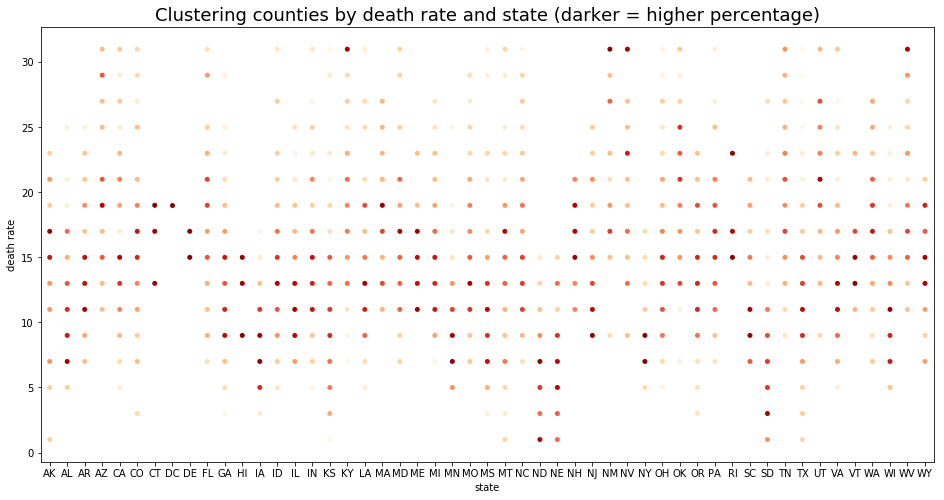

In [1816]:
plt.rcParams["figure.figsize"] = [16.0, 8.0]
ax = sns.stripplot(data=counts, x='state', y='numeric', hue='percent', palette='OrRd')
ax.legend_.remove()
ax.set_title('Clustering counties by death rate and state (darker = higher percentage)', size=18)
ax.set_ylabel('death rate')

While there are some states with outlying concentrations of counties with low or high death rates, the distribution is fairly even overall.

In [1771]:
data_31 = data.copy()
data = data[data['death_rate'] != '30+']

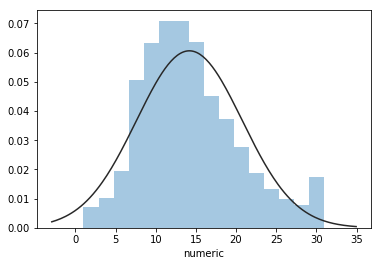

In [1772]:
from scipy.stats import norm
sns.distplot(targets['numeric'], bins=16, fit=norm, kde=False)
#targets['numeric'].hist(bins=16)

The target distribution is not normal, but it follows the general shape of a normal curve except for the high-end spike at death_rate = 31. The class imbalance will have to be dealt with. 

In [1773]:
bivariate = data.drop(['state', 'name', 'pop_2014', 'urban_influence'], axis=1).corr().abs()
print(bivariate)

               < diploma   degree+   pop_inc  foreign_inc  unemployment  \
< diploma       1.000000  0.590198  0.173795     0.014397      0.420872   
degree+         0.590198  1.000000  0.436721     0.037746      0.329834   
pop_inc         0.173795  0.436721  1.000000     0.001243      0.253635   
foreign_inc     0.014397  0.037746  0.001243     1.000000      0.003454   
unemployment    0.420872  0.329834  0.253635     0.003454      1.000000   
unemp_change    0.127994  0.117896  0.029990     0.003099      0.213587   
poverty         0.663283  0.447611  0.267106     0.014567      0.600237   
median_hh_inc   0.542180  0.680273  0.466601     0.018149      0.454140   
pov_change      0.043761  0.031475  0.047822     0.001281      0.202458   
median_age      0.221839  0.178017  0.364938     0.035829      0.061179   
hh_afr_am       0.363750  0.091370  0.102100     0.003461      0.422107   
hh_hisp         0.452917  0.020773  0.177056     0.001030      0.013150   
hh_female       0.546617 

**poverty** correlates strongly with a couple of other variables, so drop it. The two crime variables correlate strongly with each other, so combine them into one. 

In [1774]:
data['crime'] = (data['viol_crime'] + data['prop_crime'])
data = data.drop(['viol_crime', 'prop_crime', 'poverty'], axis=1)

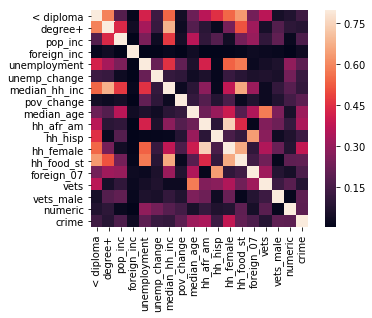

In [1775]:
corrmat = data.drop(['state', 'name', 'urban_influence', 'pop_2014', 'death_rate'], axis=1).corr().abs()
sns.heatmap(corrmat, vmax=.8, square=True)
plt.show()

There are still some strong correlations, but they are scattered. Use VIF analysis to programmatically eliminate the variables with the highest VIF scores until all scores are below 10, a conservative threshold.

In [1776]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# For each column in features, calculate VIF and save in dataframe
vif = pd.DataFrame()
remove = ['state', 'name', 'urban_influence', 'pop_2014', 'death_rate', 'numeric']
features = data.drop(remove, axis=1)
vif["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]
vif["features"] = features.columns
vif

,VIF,features
0,23.727191,< diploma
1,19.038561,degree+
2,1.649532,pop_inc
3,1.022300,foreign_inc
4,16.496006,unemployment
5,4.113846,unemp_change
6,45.701203,median_hh_inc
7,1.217936,pov_change
8,151.793720,median_age
9,4.062589,hh_afr_am


In [1777]:
max_VIF = max(vif['VIF'])
while max_VIF > 10:
    remove = remove + list(vif[vif['VIF'] == max_VIF]['features'])
    features = data.drop(remove, axis=1)
    vif = pd.DataFrame()
    vif["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]
    vif["features"] = features.columns
    max_VIF = max(vif['VIF'])
vif

,VIF,features
0,7.393791,degree+
1,1.338485,pop_inc
2,1.021619,foreign_inc
3,3.636447,unemp_change
4,1.172304,pov_change
5,2.085686,hh_afr_am
6,2.688671,hh_hisp
7,5.496295,hh_food_st
8,3.662824,foreign_07
9,9.296857,vets


In [1778]:
features1 = list(vif['features']) + ['urban_influence', 'death_rate']

In [1779]:
data1 = data.loc[:, features1]

In [1780]:
data1.describe()

,degree+,pop_inc,foreign_inc,unemp_change,pov_change,hh_afr_am,hh_hisp,hh_food_st,foreign_07,vets,crime,urban_influence
count,3024.000000,3024.000000,3024.000000,3024.000000,3024.000000,3024.000000,3024.000000,3024.000000,3024.000000,3024.000000,3024.000000,3024.000000
mean,20.936456,0.003378,0.404249,2.961078,-0.553704,0.082971,0.059307,0.102264,4.292097,0.088620,0.020376,5.205688
std,9.154237,0.041861,3.094303,1.783505,2.141838,0.139566,0.111013,0.056556,5.528622,0.022547,0.013327,3.469448
min,2.985000,-0.177510,-6.333333,-8.200000,-15.900000,0.000000,0.000000,0.000000,0.000000,0.019065,0.000000,1.000000
25%,14.571000,-0.021187,0.008944,1.800000,-1.700000,0.002650,0.009731,0.061792,1.200000,0.074239,0.011210,2.000000
50%,18.640500,-0.003907,0.059489,2.800000,-0.500000,0.013880,0.020117,0.092311,2.300000,0.087297,0.018461,5.000000
75%,24.783250,0.020743,0.204738,4.000000,0.600000,0.098243,0.052727,0.132885,5.100000,0.100467,0.027261,8.000000
max,80.210000,0.727044,119.000000,13.600000,17.400000,0.832707,0.955767,0.399738,63.100000,0.297533,0.157014,12.000000


All of the features besides the categorical **urban_influence** have strong outliers, as can be seen from the min and max values compared to the IQR.

In [1781]:
def get_outliers(df, multiplier=1.5):
    stats = df.describe()
    iqr = stats.loc['75%'] - stats.loc['25%']
    lower = stats.loc['25%'] - multiplier * iqr
    upper = stats.loc['75%'] + multiplier * iqr
    return ((df < lower) | (df > upper))

In [1782]:
predictors = data1.drop('death_rate', axis=1)

outliers = get_outliers(predictors)
len(data1[outliers.any(axis=1)])

1349

More than 1/3 of the records contain outliers, using the standard definition.

In [1783]:
strong_outliers = get_outliers(predictors, 2.0)
len(data1[strong_outliers.any(axis=1)])

1052

In [1784]:
extreme_outliers = get_outliers(predictors, 2.5)
len(data1[extreme_outliers.any(axis=1)])

845

In [1785]:
len(data1[extreme_outliers.sum(axis=1) > 1])

217

Removing even just the extreme outliers would take away almost 1/3 of the data, but removing records with 2 or more extreme outliers will reduce the dataset by only 7.5%. Try this first

In [1786]:
data1 = data1.drop(data1[extreme_outliers.sum(axis=1) > 1].index)

In [1787]:
len(data1)

2807

Try a range of classifiers. 

In [1788]:
X1 = data1.drop('death_rate', axis=1)
X1 = pd.get_dummies(X1, prefix='urb_inf_', columns=['urban_influence'])
Y1 = data1.loc[:, 'death_rate']

In [1789]:
from sklearn.preprocessing import RobustScaler
robust = RobustScaler()

from sklearn.metrics import matthews_corrcoef, make_scorer
matthews = make_scorer(matthews_corrcoef)

from sklearn.model_selection import cross_val_score

In [1790]:
from sklearn.model_selection import cross_val_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [1791]:
X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1, Y1, test_size=.35, random_state=57)

In [1792]:
knn = KNeighborsClassifier()
lrc = LogisticRegression(class_weight='balanced')
gbc = GradientBoostingClassifier()
sgd = SGDClassifier(class_weight='balanced', tol=1e-3)
rfc = RandomForestClassifier(class_weight='balanced')
svc = SVC(class_weight='balanced')

In [1793]:
classifiers = [lrc, gbc, sgd, rfc, svc, knn]
names = ['Logistic regression', 'Gradient boosting', 'SGD', 'Random forest', 'Support vector', 'K-Nearest neighbors']

def run_trials(X, Y):
    for name, clf in zip(names, classifiers):
        %time print('{} scores: {}'.format(name, cross_val_score(clf, robust.fit_transform(X), Y, scoring=matthews)))

In [1794]:
run_trials(X1_train, Y1_train)

Logistic regression scores: [ 0.05551982  0.05286564  0.06112674]
CPU times: user 564 ms, sys: 15 ms, total: 579 ms
Wall time: 203 ms
Gradient boosting scores: [ 0.05625534  0.05171995  0.06512024]
CPU times: user 8.96 s, sys: 38.8 ms, total: 9 s
Wall time: 8.58 s
SGD scores: [ 0.03277218  0.05946377  0.04898771]
CPU times: user 130 ms, sys: 3.61 ms, total: 133 ms
Wall time: 53.4 ms
Random forest scores: [ 0.0299395   0.04452084  0.05452344]
CPU times: user 569 ms, sys: 15.6 ms, total: 584 ms
Wall time: 151 ms
Support vector scores: [ 0.06175098  0.06106121  0.09220234]
CPU times: user 533 ms, sys: 5.9 ms, total: 539 ms
Wall time: 548 ms
K-Nearest neighbors scores: [ 0.04608472  0.03995855  0.04369539]
CPU times: user 90.4 ms, sys: 1.34 ms, total: 91.8 ms
Wall time: 96.2 ms


All of the stock classifiers performed poorly, with support vector doing the best, and gradient boosting and logistic regression almost tied for second place.

Try an alternative selection process starting with correlations with the target variable.

In [1795]:
bivariate = data.drop(['state', 'name', 'pop_2014', 'urban_influence'], axis=1).corr().abs()
bivariate.loc['numeric']

< diploma        0.071415
degree+          0.095094
pop_inc          0.022837
foreign_inc      0.002764
unemployment     0.289674
unemp_change     0.235700
median_hh_inc    0.180909
pov_change       0.142860
median_age       0.056238
hh_afr_am        0.116110
hh_hisp          0.067249
hh_female        0.077653
hh_food_st       0.194698
foreign_07       0.049836
vets             0.182828
vets_male        0.013722
numeric          1.000000
crime            0.191859
Name: numeric, dtype: float64

In [1796]:
features2 = list(bivariate[bivariate.loc['numeric'] > .05].index)
features2.remove('numeric')

In [1797]:
vif = pd.DataFrame()
features = data.loc[:, features2]
vif["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]
vif["features"] = features.columns
vif

,VIF,features
0,18.400137,< diploma
1,15.395662,degree+
2,15.916503,unemployment
3,4.046981,unemp_change
4,34.719466,median_hh_inc
5,1.200618,pov_change
6,71.139734,median_age
7,3.671207,hh_afr_am
8,2.370453,hh_hisp
9,28.840613,hh_female


In [1798]:
max_VIF = max(vif['VIF'])
while max_VIF > 10:
    remove = list(vif[vif['VIF'] == max_VIF]['features'])
    reduced = [feature for feature in features if feature not in remove]
    features = data.loc[:, reduced]
    vif = pd.DataFrame()
    vif["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]
    vif["features"] = features.columns
    max_VIF = max(vif['VIF'])
vif

,VIF,features
0,5.415383,degree+
1,3.569257,unemp_change
2,1.145696,pov_change
3,2.049218,hh_afr_am
4,1.447379,hh_hisp
5,5.283501,hh_food_st
6,8.603989,vets
7,4.206281,crime


(0, 0.2)

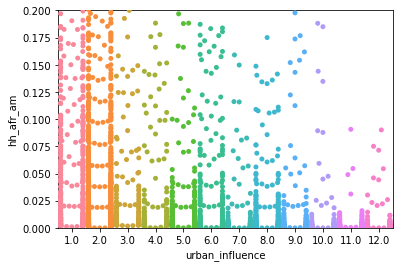

In [1799]:
sns.swarmplot(y=data['hh_afr_am'], x=data['urban_influence'])
plt.ylim(0, .2)

(0, 0.2)

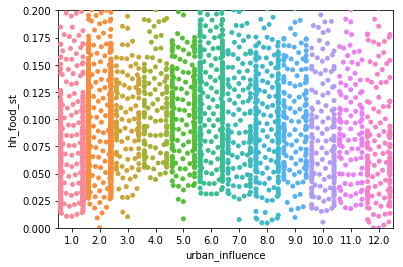

In [1800]:
sns.swarmplot(y=data['hh_food_st'], x=data['urban_influence'])
plt.ylim(0,.2)

Checking for relationships between **urban_influence** and **hh_afr_am** or **hh_food_st**, there does not appear to be any strong dependency trend in either.

In [1801]:
features2 = list(vif['features'])
data2 = data.loc[:, features2]

In [1802]:
outliers2 = get_outliers(data2)
len(data2[outliers2.any(axis=1)])

1074

In [1803]:
strong_outliers2 = get_outliers(data2, 2.0)
len(data2[strong_outliers2.any(axis=1)])

767

In [1804]:
extreme_outliers2 = get_outliers(data2, 2.5)
len(data2[extreme_outliers2.any(axis=1)])

579

In [1805]:
len(data2[extreme_outliers2.sum(axis=1) > 1])

37

In [1806]:
features2 = features2 + ['urban_influence', 'death_rate']
data2 = data.loc[:, features2]
data2 = data2.drop(list(extreme_outliers2[extreme_outliers2.sum(axis=1) > 1].index))

In [1807]:
len(data2)

2987

In [1808]:
X2 = data2.drop('death_rate', axis=1)
X2 = pd.get_dummies(X2, prefix='urb_inf_', columns=['urban_influence'])
Y2 = data2.loc[:, 'death_rate']

In [1809]:
X2_train, X2_test, Y2_train, Y2_test = train_test_split(X2, Y2, test_size=.35, random_state=57)

In [1810]:
run_trials(X2_train, Y2_train)

Logistic regression scores: [ 0.04955374  0.04176708  0.03361711]
CPU times: user 482 ms, sys: 11.6 ms, total: 493 ms
Wall time: 170 ms
Gradient boosting scores: [ 0.0310537   0.04633009  0.05927464]
CPU times: user 8.38 s, sys: 36.6 ms, total: 8.41 s
Wall time: 7.99 s
SGD scores: [ 0.024899    0.06005125  0.03717782]
CPU times: user 169 ms, sys: 2.72 ms, total: 172 ms
Wall time: 60 ms
Random forest scores: [ 0.05472505  0.07171704  0.03088483]
CPU times: user 552 ms, sys: 14 ms, total: 566 ms
Wall time: 143 ms
Support vector scores: [ 0.05217129  0.06176264  0.05187065]
CPU times: user 566 ms, sys: 5.47 ms, total: 571 ms
Wall time: 573 ms
K-Nearest neighbors scores: [ 0.05408162  0.0423971   0.04956364]
CPU times: user 75.4 ms, sys: 251 µs, total: 75.7 ms
Wall time: 75.7 ms


The scores are worse, but only 41 outliers were dropped. Look at performance with all extreme outliers removed, since the total is only 2/3 the number with the first feature set.

In [1811]:
data3 = data.loc[:, features2]
data3 = data3.drop(list(extreme_outliers2[extreme_outliers2.any(axis=1)].index))

In [1812]:
X3 = data3.drop('death_rate', axis=1)
X3 = pd.get_dummies(X3, prefix='urb_inf_', columns=['urban_influence'])
Y3 = data3.loc[:, 'death_rate']
X3_train, X3_test, Y3_train, Y3_test = train_test_split(X3, Y3, test_size=.35, random_state=57)

In [1813]:
run_trials(X3_train, Y3_train)

Logistic regression scores: [ 0.05337411  0.07724987  0.07996771]
CPU times: user 373 ms, sys: 9.36 ms, total: 383 ms
Wall time: 129 ms
Gradient boosting scores: [ 0.0328455   0.06563764  0.05411654]
CPU times: user 7.31 s, sys: 27.7 ms, total: 7.34 s
Wall time: 6.93 s
SGD scores: [ 0.03643907  0.02551089  0.06908412]
CPU times: user 171 ms, sys: 2.93 ms, total: 174 ms
Wall time: 59.8 ms
Random forest scores: [ 0.05017355  0.05703817  0.03967518]
CPU times: user 470 ms, sys: 9.09 ms, total: 480 ms
Wall time: 121 ms
Support vector scores: [ 0.07662199  0.08699553  0.07021558]
CPU times: user 437 ms, sys: 2.76 ms, total: 440 ms
Wall time: 367 ms
K-Nearest neighbors scores: [ 0.02036682  0.04189128  0.05156391]
CPU times: user 67.6 ms, sys: 183 µs, total: 67.8 ms
Wall time: 67.8 ms


Even with more outliers removed, performance was not as good as on the first feature set. Use the first set, but combine to form fewer targets.  

In [862]:
Y1_16 = Y1.apply(lambda x: '0-1.9' if x == '<2' else x)

In [863]:
def combine_targets(input):
    targets = sorted(input.unique(), key=lambda x: int(re.search('\d+(?=-)', x).group()))
    first = []
    second = []
    for i, r in enumerate(targets):
        first.append(r) if i % 2 == 0 else second.append(r)
    if len(first) != len(second):
        second.append('30-31.9')
    conversions = {}
    for start, end in zip(first, second):
        new_value = re.search('\d+-', start).group() + re.search('(?<=-)\d+.\d+', end).group()
        conversions.update(dict.fromkeys([start, end], new_value))
    return input.apply(lambda x: conversions[x])

In [864]:
Y1_8 = combine_targets(Y1_16)

In [1818]:
Y1_8_train = Y1_8[list(Y1_train.index)]
Y1_8_test = Y1_8[list(Y1_test.index)]

In [1819]:
run_trials(X1_train, Y1_8_train)

Logistic regression scores: [ 0.08832549  0.11954396  0.12411521]
CPU times: user 337 ms, sys: 12.1 ms, total: 349 ms
Wall time: 118 ms
Gradient boosting scores: [ 0.1423226   0.11936641  0.15357612]
CPU times: user 4.81 s, sys: 17.6 ms, total: 4.83 s
Wall time: 4.4 s
SGD scores: [ 0.01972545  0.09228536  0.05948445]
CPU times: user 95.2 ms, sys: 1.79 ms, total: 97 ms
Wall time: 35.5 ms
Random forest scores: [ 0.13651078  0.11300223  0.10052883]
CPU times: user 482 ms, sys: 9.59 ms, total: 492 ms
Wall time: 124 ms
Support vector scores: [ 0.14174038  0.12043186  0.18529638]
CPU times: user 509 ms, sys: 4.91 ms, total: 514 ms
Wall time: 455 ms
K-Nearest neighbors scores: [ 0.11102283  0.10053291  0.07002133]
CPU times: user 83.3 ms, sys: 406 µs, total: 83.7 ms
Wall time: 83.7 ms


There was significant improvement, but performance is still poor. Try reducing to 4 classes.

In [1821]:
Y1_4_train = combine_targets(Y1_8_train)
Y1_4_test = combine_targets(Y1_8_test)

In [1826]:
run_trials(X1_train, Y1_4_train)

Logistic regression scores: [ 0.21368678  0.27995599  0.25712266]
CPU times: user 197 ms, sys: 6.12 ms, total: 203 ms
Wall time: 68.4 ms
Gradient boosting scores: [ 0.24905532  0.26328017  0.22784672]
CPU times: user 2.63 s, sys: 17.3 ms, total: 2.65 s
Wall time: 2.22 s
SGD scores: [ 0.06243688  0.17750717  0.08615862]
CPU times: user 76.7 ms, sys: 1.78 ms, total: 78.5 ms
Wall time: 26.9 ms
Random forest scores: [ 0.18065295  0.18930584  0.18236075]
CPU times: user 436 ms, sys: 11.5 ms, total: 448 ms
Wall time: 114 ms
Support vector scores: [ 0.22886776  0.26835502  0.24347088]
CPU times: user 452 ms, sys: 3.01 ms, total: 455 ms
Wall time: 361 ms
K-Nearest neighbors scores: [ 0.21182089  0.21084499  0.18736939]
CPU times: user 76.5 ms, sys: 183 µs, total: 76.7 ms
Wall time: 76.7 ms


In [1823]:
Y1_2_train = combine_targets(Y1_4_train)
Y1_2_test = combine_targets(Y1_4_test)

In [1827]:
run_trials(X1_train, Y1_2_train)

Logistic regression scores: [ 0.3605477   0.38500583  0.41100902]
CPU times: user 32.3 ms, sys: 1.87 ms, total: 34.2 ms
Wall time: 33.2 ms
Gradient boosting scores: [ 0.33713757  0.29060624  0.37415019]
CPU times: user 528 ms, sys: 1.92 ms, total: 530 ms
Wall time: 530 ms
SGD scores: [ 0.29287073  0.30316662  0.30566928]
CPU times: user 24.5 ms, sys: 228 µs, total: 24.7 ms
Wall time: 24.6 ms
Random forest scores: [ 0.21268015  0.29380515  0.30487196]
CPU times: user 97.7 ms, sys: 273 µs, total: 98 ms
Wall time: 98 ms
Support vector scores: [ 0.36396648  0.38650955  0.44225272]
CPU times: user 229 ms, sys: 1.68 ms, total: 230 ms
Wall time: 234 ms
K-Nearest neighbors scores: [ 0.24806051  0.31106316  0.28854924]
CPU times: user 80.2 ms, sys: 532 µs, total: 80.8 ms
Wall time: 81.2 ms


It appears that binary classification is the best that the data can do resonably well. The support vector classifier performed best, with logistic regression second. See how they do on the test set.

In [1831]:
svc.fit(robust.fit_transform(X1_train), Y1_2_train)
matthews_corrcoef(Y1_2_test, svc.predict(robust.fit_transform(X1_test)))

0.38194833928252886

In [1834]:
lrc.fit(robust.fit_transform(X1_train), Y1_2_train)
matthews_corrcoef(Y1_2_test, lrc.predict(robust.fit_transform(X1_test)))

0.40766998602465093

Logistic regression performs better on the test set and is more interpretable, so proceed with that as the classifier to optimize. A quick check of results with and without the **30+** target values showed that the model performs better with them included, so leave them in.

In [1835]:
binary = data_31.copy()
binary['crime'] = (binary['viol_crime'] + binary['prop_crime'])
binary = binary.drop(['viol_crime', 'prop_crime'], axis=1)
binary = binary.loc[:, features1]

binary.loc[:, 'death_rate'] = binary['death_rate'].apply(lambda x: '30-31.9' if x == '30+' else x)

In [1836]:
X = binary.drop('death_rate', axis=1)
X = pd.get_dummies(X, prefix='urb_inf_', columns=['urban_influence'])
Y = binary.loc[:, 'death_rate']

In [1837]:
Y_16 = Y.apply(lambda x: '0-1.9' if x == '<2' else x)
Y_8 = combine_targets(Y_16)
Y_4 = combine_targets(Y_8)
Y_2 = combine_targets(Y_4)

Repeat the basic process with the additional samples.

In [1838]:
def run_clf(clf, data, targets, rand, t_size=0.35):
    X_train, X_test, Y_train, Y_test = train_test_split(data, targets, random_state=rand, test_size=t_size)
    print('Training scores: {}'.format(cross_val_score(clf, center.fit_transform(X_train), Y_train,
                                                                    scoring=matthews)))
    clf.fit(center.fit_transform(X_train), Y_train)
    print('Test score: {}'.format(matthews_corrcoef(Y_test, clf.predict(center.fit_transform(X_test)))))

In [1839]:
clf = LogisticRegression(class_weight='balanced')

In [1841]:
extreme_outliers = get_outliers(binary.drop(['urban_influence', 'death_rate'], axis=1), 2.5)

*Note: With the one-hot encoding of the __urban_influence__ variable, the mean for each binary feature is small, and most have 1st and 3rd quartile values of zero, so a 1 is always classified as an "extreme outlier." As a result, these features must be excluded from an outlier search.*

In [1842]:
X_no_xx = X[~(extreme_outliers.sum(axis=1) > 1)]
Y_no_xx = Y_2[~(extreme_outliers.sum(axis=1) > 1)]
len(Y_no_xx)

2904

In [1843]:
X_no_x = X[~extreme_outliers.any(axis=1)]
Y_no_x = Y_2[~extreme_outliers.any(axis=1)]
len(Y_no_extreme)

2249

In [1844]:
run_clf(clf, X, Y_2, 77)

Training scores: [ 0.3659125   0.39934076  0.42940491]
Test score: 0.37677726988394494


In [1845]:
run_clf(clf, X_no_xx, Y_no_xx, 77)

Training scores: [ 0.40464457  0.41579804  0.38542681]
Test score: 0.4073201746176321


In [1846]:
run_clf(clf, X_no_x, Y_no_x, 77)

Training scores: [ 0.37256039  0.3979989   0.37648975]
Test score: 0.4152970745557789


It seems performance is better with just the most extreme outliers removed. With all the extreme outliers removed, the test results were better, but they also were better than the training scores, suggesting that the model was unstable. Try another split with a different seed.

In [1847]:
run_clf(clf, X, Y_2, 23)

Training scores: [ 0.41232672  0.40859137  0.40683444]
Test score: 0.3785868689370292


In [1848]:
run_clf(clf, X_no_xx, Y_no_xx, 23)

Training scores: [ 0.41176627  0.41797922  0.42805868]
Test score: 0.34650278518605054


In [1849]:
run_clf(clf, X_no_x, Y_no_x, 23)

Training scores: [ 0.39069758  0.34941506  0.37793724]
Test score: 0.39781598007893043


Now the results are muddied. Try one more split.

In [1850]:
run_clf(clf, X, Y_2, 13)

Training scores: [ 0.35485655  0.38603222  0.42577718]
Test score: 0.36601216796250713


In [1851]:
run_clf(clf, X_no_xx, Y_no_xx, 13)

Training scores: [ 0.39697358  0.38951324  0.3780451 ]
Test score: 0.4162781030006335


In [1852]:
run_clf(clf, X_no_x, Y_no_x, 13)

Training scores: [ 0.36138532  0.3964418   0.34842314]
Test score: 0.4309497088676196


Removing all the extreme outliers produced consistently better test results, even though removing just the most extreme outliers achieved the single best test score. It will be the model to optimize.

In [1853]:
from sklearn.model_selection import GridSearchCV

In [1904]:
X_train, X_test, Y_train, Y_test = train_test_split(X_no_x, Y_no_x, test_size=.25, random_state=13)

In [1905]:
params = [{ 'penalty': ['l1', 'l2'], 'tol': [1e-4, 1e-3], 'C': [1e-2, 1e-1, 1, 2, 3, 4, 5], 'solver': ['liblinear'], 'multi_class': ['ovr']},
        { 'penalty': ['l2'], 'tol': [1e-4, 1e-3], 'C': [1e-2, 1e-1, 1, 2, 3, 4, 5], 'solver': ['newton-cg', 'lbfgs'], 'multi_class': ['ovr', 'multinomial']}]  
model = GridSearchCV(clf, param_grid=params, scoring=matthews)
model.fit(center.fit_transform(X_train), Y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'penalty': ['l1', 'l2'], 'tol': [0.0001, 0.001], 'C': [0.01, 0.1, 1, 2, 3, 4, 5], 'solver': ['liblinear'], 'multi_class': ['ovr']}, {'penalty': ['l2'], 'tol': [0.0001, 0.001], 'C': [0.01, 0.1, 1, 2, 3, 4, 5], 'solver': ['newton-cg', 'lbfgs'], 'multi_class': ['ovr', 'multinomial']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(matthews_corrcoef), verbose=0)

In [1906]:
model.best_params_

{'C': 0.01,
 'multi_class': 'multinomial',
 'penalty': 'l2',
 'solver': 'newton-cg',
 'tol': 0.0001}

The sag and saga solvers did not converge, and neither did the other solvers for tolerance values below .0001

In [1907]:
matthews_corrcoef(Y_test, model.predict(center.fit_transform(X_test)))

0.43840428027647016

In [1908]:
X_train, X_test, Y_train, Y_test = train_test_split(X_no_x, Y_no_x, test_size=.25, random_state=97)
model.fit(center.fit_transform(X_train), Y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'penalty': ['l1', 'l2'], 'tol': [0.0001, 0.001], 'C': [0.01, 0.1, 1, 2, 3, 4, 5], 'solver': ['liblinear'], 'multi_class': ['ovr']}, {'penalty': ['l2'], 'tol': [0.0001, 0.001], 'C': [0.01, 0.1, 1, 2, 3, 4, 5], 'solver': ['newton-cg', 'lbfgs'], 'multi_class': ['ovr', 'multinomial']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(matthews_corrcoef), verbose=0)

In [1909]:
model.best_params_

{'C': 3,
 'multi_class': 'multinomial',
 'penalty': 'l2',
 'solver': 'newton-cg',
 'tol': 0.0001}

In [1910]:
matthews_corrcoef(Y_test, model.predict(center.fit_transform(X_test)))

0.43654570479148536

Rearranging the samples leads to the grid search choosing a very different C parameter. This could indicate instability. However, experimentation showed a test set of 0.25 to give stable results. The original test size of .35 produced results of around .45 and .41, whereas reducing the test size to 0.2 exaggerates this difference to about .47 and .39. Out of curiosity, what is the result from optimizing the dataset with just the most extreme outliers removed. 

In [1911]:
X2_train, X2_test, Y2_train, Y2_test = train_test_split(X_no_xx, Y_no_xx, test_size=.25, random_state=13)
model2 = GridSearchCV(clf, param_grid=params, scoring=matthews)
model2.fit(robust.fit_transform(X2_train), Y2_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'penalty': ['l1', 'l2'], 'tol': [0.0001, 0.001], 'C': [0.01, 0.1, 1, 2, 3, 4, 5], 'solver': ['liblinear'], 'multi_class': ['ovr']}, {'penalty': ['l2'], 'tol': [0.0001, 0.001], 'C': [0.01, 0.1, 1, 2, 3, 4, 5], 'solver': ['newton-cg', 'lbfgs'], 'multi_class': ['ovr', 'multinomial']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(matthews_corrcoef), verbose=0)

In [1912]:
model2.best_params_

{'C': 0.1,
 'multi_class': 'multinomial',
 'penalty': 'l2',
 'solver': 'newton-cg',
 'tol': 0.0001}

In [1913]:
matthews_corrcoef(Y2_test, model2.predict(robust.fit_transform(X2_test)))

0.41195095043131535

In [1914]:
X2_train, X2_test, Y2_train, Y2_test = train_test_split(X_no_xx, Y_no_xx, test_size=.35, random_state=97)
model2.fit(robust.fit_transform(X2_train), Y2_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'penalty': ['l1', 'l2'], 'tol': [0.0001, 0.001], 'C': [0.01, 0.1, 1, 2, 3, 4, 5], 'solver': ['liblinear'], 'multi_class': ['ovr']}, {'penalty': ['l2'], 'tol': [0.0001, 0.001], 'C': [0.01, 0.1, 1, 2, 3, 4, 5], 'solver': ['newton-cg', 'lbfgs'], 'multi_class': ['ovr', 'multinomial']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(matthews_corrcoef), verbose=0)

In [1915]:
model2.best_params_

{'C': 0.1,
 'multi_class': 'multinomial',
 'penalty': 'l2',
 'solver': 'newton-cg',
 'tol': 0.0001}

In [1916]:
matthews_corrcoef(Y2_test, model.predict(robust.fit_transform(X2_test)))

0.42361487173310902

In [1687]:
residuals = model.best_estimator_.decision_function(X_test)
max(residuals)

37.137991509151298

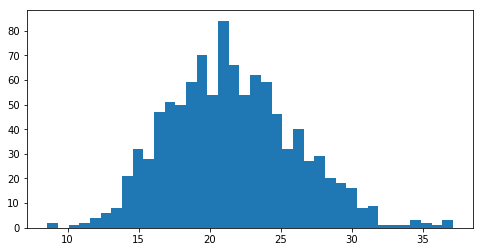

In [1689]:
fig = plt.hist(residuals, bins=38)

The residuals show a relatively normal distribution.

In [1670]:
feature_rank = zip(X_train.columns, model.best_estimator_.coef_[0])
results = sorted(feature_rank, key=lambda tup: tup[1], reverse=True)
for f, r in results:
    print('{:13.12}: {:8.5f}  OR:{:5.2f} '.format(f, r, np.exp(r)))


hh_food_st   :  0.94216  OR: 2.57 
< diploma    :  0.92706  OR: 2.53 
urb_inf__1.0 :  0.78470  OR: 2.19 
crime        :  0.61066  OR: 1.84 
vets         :  0.56519  OR: 1.76 
unemp_change :  0.49094  OR: 1.63 
degree+      :  0.35392  OR: 1.42 
urb_inf__10. :  0.12858  OR: 1.14 
urb_inf__3.0 :  0.09787  OR: 1.10 
urb_inf__7.0 :  0.09532  OR: 1.10 
urb_inf__11. :  0.08436  OR: 1.09 
urb_inf__2.0 :  0.04876  OR: 1.05 
foreign_07   :  0.00000  OR: 1.00 
urb_inf__4.0 :  0.00000  OR: 1.00 
foreign_inc  : -0.00172  OR: 1.00 
hh_hisp      : -0.04202  OR: 0.96 
pop_inc      : -0.06472  OR: 0.94 
urb_inf__12. : -0.26275  OR: 0.77 
urb_inf__9.0 : -0.30283  OR: 0.74 
pov_change   : -0.32699  OR: 0.72 
urb_inf__6.0 : -0.50483  OR: 0.60 
urb_inf__8.0 : -0.52231  OR: 0.59 
hh_afr_am    : -0.77844  OR: 0.46 
urb_inf__5.0 : -1.20987  OR: 0.30 


In [1667]:
model.best_estimator_.coef_[0]

array([ 0.92706082,  0.3539223 , -0.06472313, -0.00172208,  0.49094124,
       -0.32698916, -0.77843754, -0.04202352,  0.94215895,  0.        ,
        0.56519276,  0.61066334,  0.78470151,  0.04875627,  0.09786984,
        0.        , -1.2098678 , -0.50483155,  0.0953173 , -0.52230635,
       -0.3028268 ,  0.12858273,  0.08435988, -0.26275136])